In [1]:
import sys
sys.path.append("/home/ross/CytoPyEcosystem/CytoCluster")

In [58]:
# Imports
from cytotools.read import read_from_disk, polars_to_pandas
from cytotools.dimension_reduction import DimensionReduction
from cytotools.transform import apply_transform
from cytocluster.single import SingleClustering
from cytocluster.methods.utils import build_clustering_method
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="ticks", font_scale=1.3)
%matplotlib inline

# Individual clustering

In this example notebook I will show how you can use CytoCluster to perform clustering analysis using popular algorithms from the cytometry literature.

## Preparing example data

I'm going to use the Levine-32 dataset from here (https://github.com/lmweber/benchmark-data-Levine-32-dim)

In [3]:
# Read the Levine32 FCS file from disk
# By default, CytoTools reads data in as Polars dataframe, but we can easily convert to a Pandas DataFrame
data = polars_to_pandas(read_from_disk("data/Levine_32dim_notransform.fcs"))
data.head()

,Time,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,...,CD117,CD49d,HLA-DR,CD64,CD41,Viability,file_number,event_number,label,individual
Index,,,,,,,,,,,,,,,,,,,,,
0,2693.0,22.0,201.783295,253.016647,0.817049,-0.147947,-0.033482,0.332183,-0.045922,1.858334,...,0.265375,4.804858,12.734092,-0.026878,-0.009804,3.474168,94.0,307.0,1.0,1.0
1,3736.0,35.0,191.828598,308.869080,3.801385,-0.191446,-0.083274,0.372388,4.494379,-0.177158,...,0.448901,0.995556,2.558165,0.726602,4.905976,2.956692,94.0,545.0,1.0,1.0
2,7015.0,32.0,116.111923,200.839218,3.204439,-0.161106,0.369613,-0.214952,-0.009404,-0.043904,...,0.231194,33.025459,8.574364,-0.054804,-0.052067,3.443209,94.0,1726.0,1.0,1.0
3,7099.0,29.0,176.248505,313.022461,2.237382,-0.138071,-0.088311,-0.220430,4.006598,-0.095335,...,0.332596,8.879428,0.704930,-0.067247,-0.130211,-0.132632,94.0,1766.0,1.0,1.0
4,7700.0,25.0,133.332779,226.467758,-0.044047,-0.151509,0.402548,2.581769,6.742060,2.906627,...,-0.031117,0.909562,0.993077,0.381205,-0.202496,1.435457,94.0,2031.0,1.0,1.0


In [4]:
# Replace the labels with more intuitive population names
populations = pd.read_csv("data/levine32_populations.csv")
mappings = {x["label"]: x["population"] for x in populations.to_dict("records")}
data["label"] = data["label"].replace(mappings)
data.rename(columns={"label": "Ground Truth", "individual": "sample_id"}, inplace=True)

For the purposes of this tutorial, I'm going to remove events that do not have a ground truth label.

In [5]:
data = data[~data["Ground Truth"].isnull()].copy()

## Prepare a clustering object

The `SingleClustering` class from CytoCluster provides all the functionality for applying a single clustering algorithm to data and generating cluster labels. In the next notebook titled "Ensemble clustering" I will use the `EnsembleClustering` class to combine multiple clustering labels to generate a final clustering solution.

A `SingleClustering` object can be constructed using the `from_dataframe` method. **Note: the data must contain a column called 'sample_id'**, this is why in the code cell above I renamed the column 'individual'.

Then the `transform` method can be used to apply a transformation to our features - we will apply a Arcsinh transform with a cofactor of 100.

In [6]:
features = [
    'CD45RA', 'CD133', 'CD19', 'CD22', 'CD11b', 'CD4', 'CD8', 'CD34',
    'Flt3', 'CD20', 'CXCR4', 'CD235ab', 'CD45', 'CD123', 'CD321',
    'CD14', 'CD33', 'CD47', 'CD11c', 'CD7', 'CD15', 'CD16', 'CD44',
    'CD38', 'CD13', 'CD3', 'CD61', 'CD117', 'CD49d', 'HLA-DR', 'CD64', 'CD41'
]

clustering = SingleClustering.from_dataframe(
    data=data,
    features=features,
    verbose=True,
    random_state=42,
    pre_embedded=False
)

Note that I set `pre_embedded` to False. This means that I have not already performed dimension reduction and no columns in the dataframe correspond to latent variables generated by a technique such as tSNE or UMAP. I will come back to this later but for now we will leave this as False.

In [7]:
# I can either specify which features to transform by passing a list of column names to the 'features' argument
# or leave 'features' as None, transforming all the features specified when I constructed the object
clustering.transform_features(method="asinh", cofactor=100)

In [8]:
clustering

Clustering object
data: 104184 observations, 32 features, 43 columns
N samples: 2
pre-embedded latent variables: False
embeddings cache: False

We now have a `Clustering` object that has a bunch of functions that make clustering cytometry data and visualising results easy. The main property of interest on this object is `data`. This will store the results:

* cluster_label: this column will contain the cluster labels
* meta_label: this will contain meta cluster labels (meta clustering in this context is where each sample is clustered individually and then the clusters from all individuals are clustered into meta-clusters. This is beyond the scope of this tutorial but for further details see the Phenograph paper, Levine et al 2015, or CytoPy paper, Burton et al 2021).

In [9]:
clustering.data.head()

,Time,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,...,HLA-DR,CD64,CD41,Viability,file_number,event_number,Ground Truth,sample_id,meta_label,cluster_label
Index,,,,,,,,,,,,,,,,,,,,,
0,2693.0,22.0,201.783295,253.016647,0.008170,-0.001479,-0.000335,0.003322,-0.000459,0.018582,...,0.126999,-0.000269,-0.000098,3.474168,94.0,307.0,Basophils,1.0,None,None
1,3736.0,35.0,191.828598,308.869080,0.038005,-0.001914,-0.000833,0.003724,0.044929,-0.001772,...,0.025579,0.007266,0.049040,2.956692,94.0,545.0,Basophils,1.0,None,None
2,7015.0,32.0,116.111923,200.839218,0.032039,-0.001611,0.003696,-0.002150,-0.000094,-0.000439,...,0.085639,-0.000548,-0.000521,3.443209,94.0,1726.0,Basophils,1.0,None,None
3,7099.0,29.0,176.248505,313.022461,0.022372,-0.001381,-0.000883,-0.002204,0.040055,-0.000953,...,0.007049,-0.000672,-0.001302,-0.132632,94.0,1766.0,Basophils,1.0,None,None
4,7700.0,25.0,133.332779,226.467758,-0.000440,-0.001515,0.004025,0.025815,0.067370,0.029062,...,0.009931,0.003812,-0.002025,1.435457,94.0,2031.0,Basophils,1.0,None,None


The 'embedding cache' attribute (currently False) specifies whether a dimension reduction technique has been applied and the results cached for plotting. I will discuss this next.

## Dimension reduction and plotting

One of the common tasks when performing clustering analysis is plotting the data for visualisation. For this we often use techniques like tSNE, UMAP, or PHATE to reduce the dimensionality of our data. These techniques tend to be computationally expensive, therefore the `Clustering` class implements two features:

* Downsampling to reduce the complexity of this task - sampling is performed per sample ID so that each individual is equally represented
* Caching of results so that expensive computations don't have to be repeated

Whenever the chosen dimension reduction method is changed, the cache is overwritten, however we can manually overwrite the cache by specifying the `overwrite_cache` argument to True when performing dimension reduction.

Below I call the `dimension_reduction` method to generate 2 UMAP features. By specifying a sample size of 10000, this ensures that 5000 events are sampled from each patient, giving me a total of 20000 data points in my embedding. The function returns a DataFrame with the columns UMAP1 and UMAP2, this dataframe is what is cached within the `Clustering` object.

In [10]:
embeddings = clustering.dimension_reduction(n=10000, method="UMAP", n_components=2, random_state=42)
embeddings.head()

,Time,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,...,CD41,Viability,file_number,event_number,Ground Truth,sample_id,meta_label,cluster_label,UMAP1,UMAP2
Index,,,,,,,,,,,,,,,,,,,,,
5785,117720.0,34.0,186.013565,435.251831,-0.000485,0.014701,0.012303,0.011881,0.012448,0.015730,...,0.028896,1.112924,94.0,122834.0,CD34+CD38+CD123-_HSPCs,1.0,None,None,12.580168,2.323237
63569,382080.0,20.0,125.951019,242.735275,0.034175,-0.000854,-0.000608,-0.001797,0.231051,-0.000878,...,-0.000501,1.528373,94.0,305883.0,Monocytes,1.0,None,None,14.780414,11.725983
54485,82397.0,23.0,107.574280,205.927032,0.059191,0.013404,-0.001265,0.010144,0.113805,-0.001656,...,0.013296,5.243573,94.0,82770.0,Monocytes,1.0,None,None,12.832126,12.907092
40353,37111.0,38.0,85.816025,193.397858,0.015930,0.018115,0.138518,0.091578,0.008417,0.015518,...,0.033573,3.288250,94.0,27862.0,Mature_B_cells,1.0,None,None,8.259011,7.461109
12913,139229.0,34.0,130.995483,243.258972,0.012503,-0.000690,-0.002219,-0.000931,0.004034,0.012421,...,0.003584,1.623088,94.0,141310.0,CD4_T_cells,1.0,None,None,-2.255832,6.339335


With the embeddings cached, I can now call our plotting methods to visualise the data, starting with a density plot:

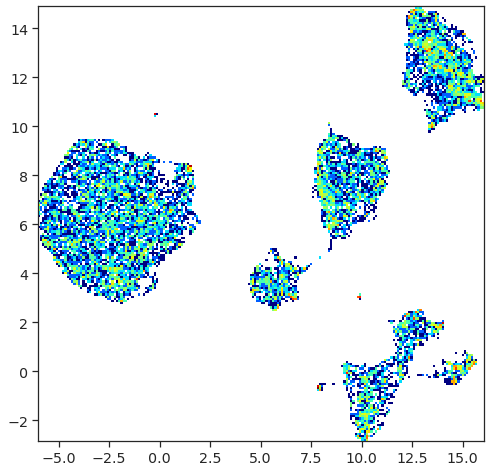

In [11]:
# Because the dimension reduction method hasn't changed and 'overwrite_cache' is False, it will use the cached embeddings to generate
# this plot
clustering.plot_density(method="UMAP", overwrite_cache=False, bins=200)
plt.show()

The `plot` function allows for plotting any label of choice on your data, so I can plot the ground truth labels for example:

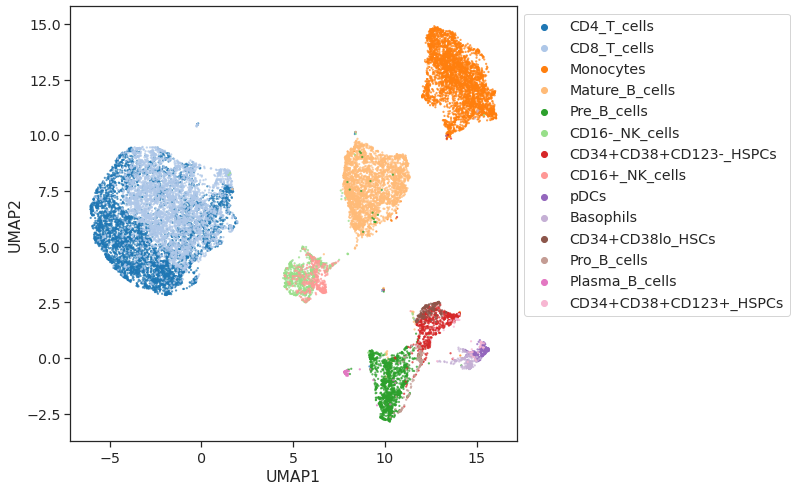

In [12]:
clustering.plot(
    label="Ground Truth",
    discrete=True,
    method="UMAP",
    overwrite_cache=False,
    include_legend=True,
    legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0))
)
plt.show()

In [13]:
clustering.data

,Time,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,...,HLA-DR,CD64,CD41,Viability,file_number,event_number,Ground Truth,sample_id,meta_label,cluster_label
Index,,,,,,,,,,,,,,,,,,,,,
0,2693.0000,22.0,201.783295,253.016647,0.008170,-0.001479,-0.000335,0.003322,-0.000459,0.018582,...,0.126999,-0.000269,-0.000098,3.474168,94.0,307.0,Basophils,1.0,None,None
1,3736.0000,35.0,191.828598,308.869080,0.038005,-0.001914,-0.000833,0.003724,0.044929,-0.001772,...,0.025579,0.007266,0.049040,2.956692,94.0,545.0,Basophils,1.0,None,None
2,7015.0000,32.0,116.111923,200.839218,0.032039,-0.001611,0.003696,-0.002150,-0.000094,-0.000439,...,0.085639,-0.000548,-0.000521,3.443209,94.0,1726.0,Basophils,1.0,None,None
3,7099.0000,29.0,176.248505,313.022461,0.022372,-0.001381,-0.000883,-0.002204,0.040055,-0.000953,...,0.007049,-0.000672,-0.001302,-0.132632,94.0,1766.0,Basophils,1.0,None,None
4,7700.0000,25.0,133.332779,226.467758,-0.000440,-0.001515,0.004025,0.025815,0.067370,0.029062,...,0.009931,0.003812,-0.002025,1.435457,94.0,2031.0,Basophils,1.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104179,641812.4375,58.0,2308.310303,3518.157471,-0.000005,-0.001532,0.098584,-0.002248,-0.000827,0.019970,...,0.263008,-0.000231,-0.002581,0.792357,98.0,100344.0,Pro_B_cells,2.0,None,None
104180,653387.4375,55.0,1997.182739,3237.193604,0.037461,-0.001867,0.123590,0.014512,-0.001850,-0.002266,...,1.430100,0.003136,0.007966,0.126289,98.0,100892.0,Pro_B_cells,2.0,None,None
104181,671024.4375,40.0,2509.493408,3193.563232,-0.001840,-0.000724,0.123445,-0.001090,-0.001009,-0.001775,...,0.780554,0.005530,0.005428,-0.218764,98.0,101558.0,Pro_B_cells,2.0,None,None


You can also plot continuous variables:

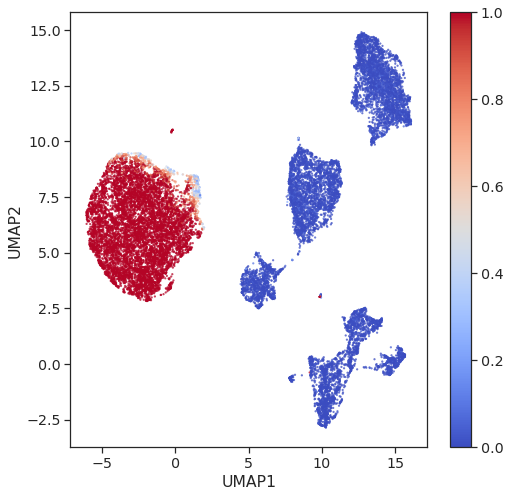

In [14]:
clustering.plot(
    label="CD3",
    discrete=False,
    method="UMAP",
    overwrite_cache=False,
)
plt.show()

I mentioned before that you can perform dimension reduction prior to constructing you clustering object. This might be preferable if you have sufficient computer power because you can generate embeddings for all available data. This is often beyond the resource available for experiments with many subjects and millions of data points.

If I were to do this, I can use the `DimensionReduction` class from CytoTools.

In [7]:
reducer = DimensionReduction(method="UMAP", n_components=2, n_jobs=-1, n_neighbors=30)
data_with_embeddings = apply_transform(data=data.copy(), features=features, method="asinh", cofactor=100)
data_with_embeddings = reducer.fit_transform(data=data_with_embeddings, features=features)

I now reconstruct my `Clustering` object but this time I specify `pre_embedded` as True. This now means that for all plotting the pre-computed embeddings will be used and caching will be ignored. I could also optionally set the features to the UMAP embeddings, meaning that clustering would be performed on the embeddings rather than the original features.

Clustering on the latent variables can also be achieved with the `LatentClustering` class in CytoCluster which allows for down-sampling to overcome computational complexity and subsequent upsampling by K-nearest neighbours, similar to the SPADE algorithm.

In [8]:
clustering = SingleClustering.from_dataframe(
    data=data_with_embeddings,
    features=features,
    verbose=True,
    random_state=42,
    pre_embedded=True
)

In [9]:
clustering

Clustering object
data: 104184 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

All the same plots can be generated but now with more data and

<AxesSubplot:>

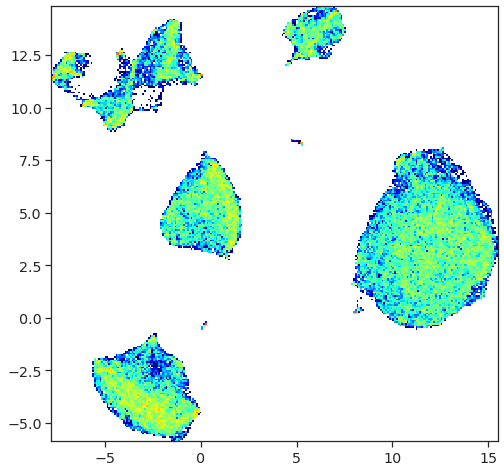

In [10]:
clustering.plot_density(bins=250)

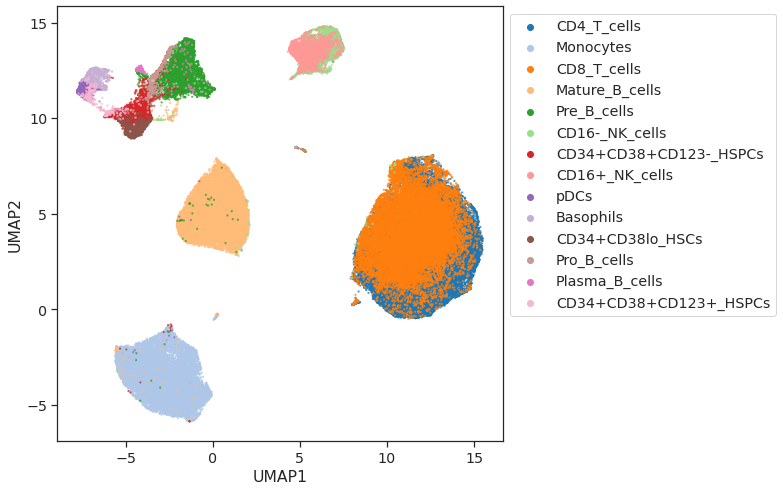

In [11]:
clustering.plot(
    label="Ground Truth",
    discrete=True,
    method="UMAP",
    overwrite_cache=False,
    include_legend=True,
    legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0))
)
plt.show()

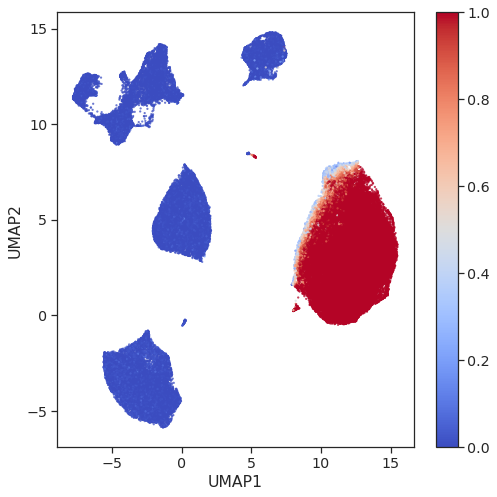

In [12]:
clustering.plot(
    label="CD3",
    discrete=False,
    method="UMAP",
    overwrite_cache=False
)
plt.show()

## Clustering analysis

Clustering analysis can be performed with one of the three following methods:

* local_clustering: clusters data grouped on sample ID, meaning each individual is clustered separately and the cluster labels are relative to the sample ID.
* meta_clustering: to be performed after local clustering, the clusters from each individual are clustered into meta-clusters of similar phenotype.
* global_clustering: all data is clustered together.

In this notebook I will only be covering global clustering as that is the most common technique used and relevant to the wider audience.

CytoCluster exposes some of the most popular clustering algorithms but supports any clustering algorithm that has Scikit-Learn signatures. The clustering algorithm itself is wrapped by the `ClusterMethod` class, but for convenience we only have to pass either a valid clustering object (e.g. KMeans object from Scikit-Learn) or a string value. If we pass a string it should be one of the following supported methods:

* phenograph - graph based clustering using community detection (Louvain method)
* parc - optimised version of phenograph
* flowsom - self-organising maps
* spade - density-dependent down sampling with hierarchical clustering and then up sampling by nearest
neighbours
* k_consensus - consensus clustering with automated selection of K
* latent - choice of any ClusterMethod but applied to embedding from a method such as UMAP, tSNE or PHATE

Below I'm going to show an example from each of the most popular methods as well as some Scikit-Learn algorithms.

In [13]:
clustering = SingleClustering.from_dataframe(
    data=data_with_embeddings.sample(10000),
    features=features,
    verbose=True,
    random_state=42,
    pre_embedded=True
)

### FlowSOM

In [51]:
clustering.global_clustering(
    method="flowsom",
    clustering_params=dict(
        som_dim=(15, 15), learning_rate=0.4, batch_size=100, sigma=0.1
    )
)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.6016950270404148


/home/ross/.cache/pypoetry/virtualenvs/cytocluster-9ecCQAJO-py3.8/lib/python3.8/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

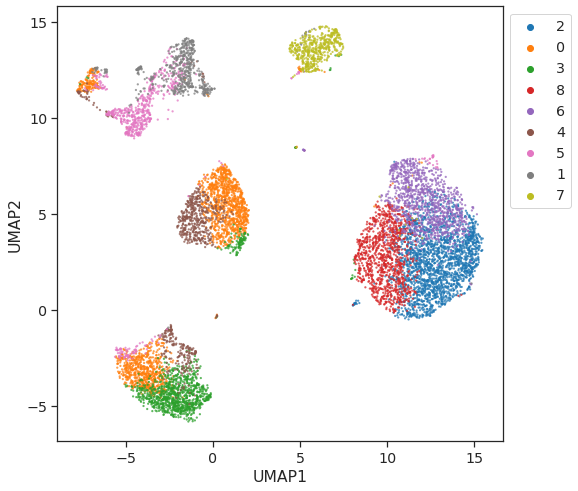

In [52]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

In [53]:
clustering.global_clustering(
    method="flowsom",
    overwrite_features=["UMAP1", "UMAP2"],
    clustering_params=dict(
        som_dim=(15, 15), learning_rate=0.4, batch_size=100, sigma=0.1
    )
)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.31927450969619875


/home/ross/.cache/pypoetry/virtualenvs/cytocluster-9ecCQAJO-py3.8/lib/python3.8/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

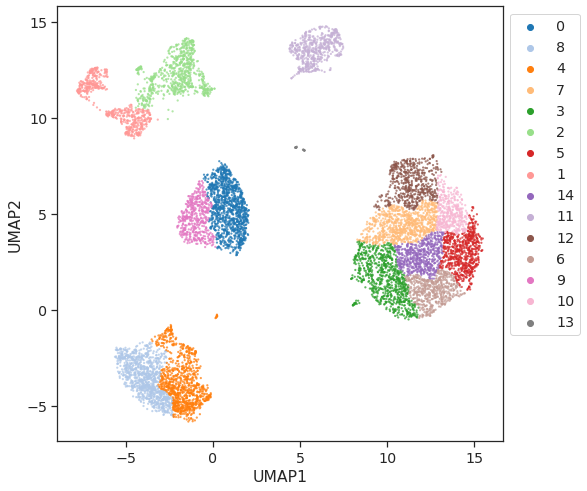

In [54]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

In [60]:
flowsom_params = dict(
    som_dim=(15, 15), learning_rate=0.4, batch_size=100, sigma=0.1
)

clustering.global_clustering(
    method="latent",
    clustering_params=dict(
        cluster_method=build_clustering_method("flowsom", **flowsom_params),
        dimension_reduction=DimensionReduction(method="UMAP", n_components=2),
        sample_size=1000
    )
)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.13597062473527638


/home/ross/.cache/pypoetry/virtualenvs/cytocluster-9ecCQAJO-py3.8/lib/python3.8/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

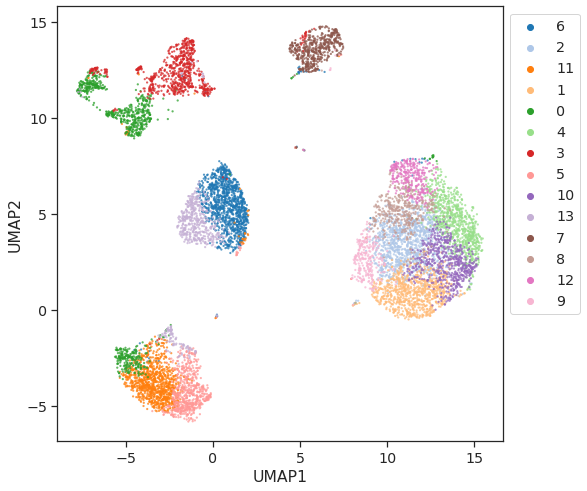

In [61]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

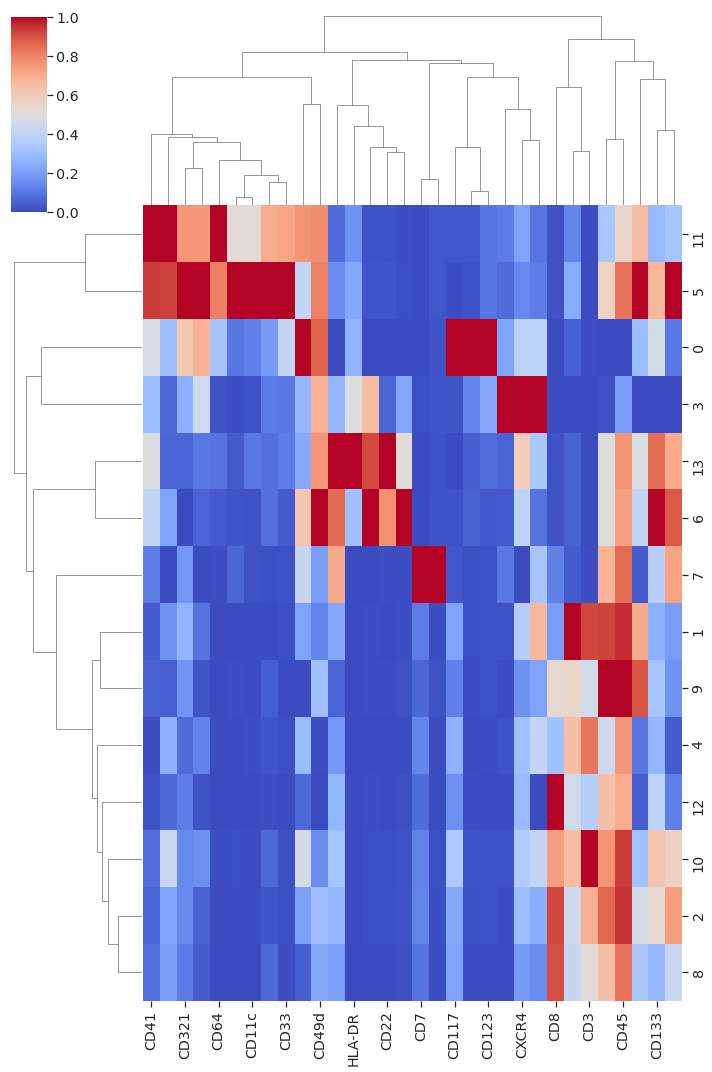

In [67]:
clustering.heatmap(meta_label=False, cmap="coolwarm", standard_scale=1)

In [69]:
clustering.simpsons_diversity_index().head()

,Cluster,Simpson's Diversity Index
0,0,0.584484
1,1,0.519160
2,10,0.611454
3,11,0.712718
4,12,0.547878


<AxesSubplot:xlabel='Cluster', ylabel="Simpson's Diversity Index">

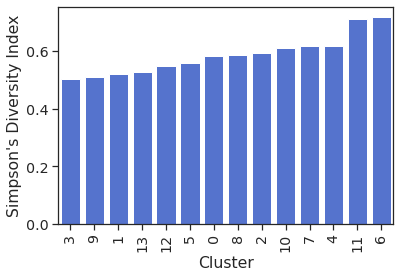

In [70]:
clustering.plot_simpsons_diversity_index()

<AxesSubplot:xlabel='cluster_label', ylabel='Percentage'>

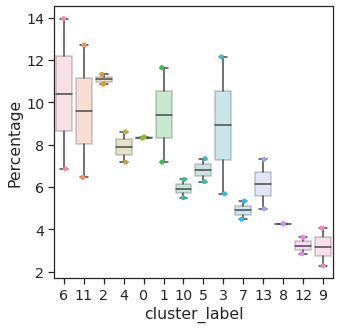

In [71]:
clustering.cluster_proportions()

In [79]:
clustering.internal_performance(sample_n=2500, resamples=10, balance_clusters=False, balance_samples=False)

  0%|          | 0/10 [00:00<?, ?it/s]

,Distortion score,Silhouette Coefficient,Davies-Bouldin index,Calinski and Harabasz score
0,4708.670013,0.131199,1.728309,889.081116
1,4774.459924,0.132453,1.726619,878.241119
2,4822.303290,0.131387,1.702940,870.922323
3,4765.709130,0.133060,1.711073,894.789956
4,4758.393125,0.130436,1.730771,889.180290
5,4803.173112,0.133100,1.720652,877.061432
6,4760.889303,0.134618,1.712943,889.527348
7,4752.583208,0.130840,1.712526,883.605413
8,4715.293010,0.131475,1.720579,891.896856
9,4749.031332,0.130330,1.715171,895.274514


In [82]:
results, fig = clustering.performance(sample_n=2500, resamples=10)

  0%|          | 0/10 [00:00<?, ?it/s]

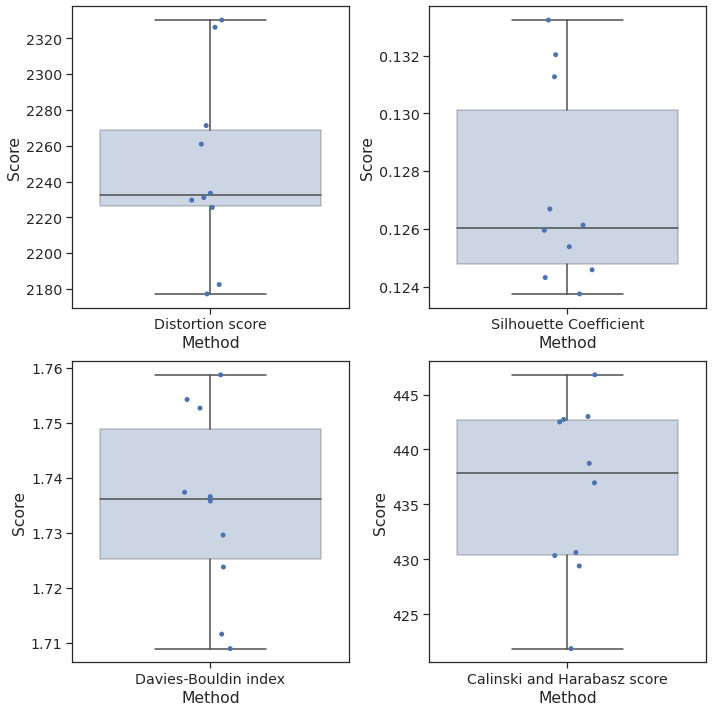

In [85]:
fig.tight_layout()
fig

### Phenograph

In [86]:
clustering.global_clustering(method="phenograph")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4230194091796875 seconds
Jaccard graph constructed in 0.7287111282348633 seconds
Wrote graph to binary file in 0.06497788429260254 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.837544
Louvain completed 21 runs in 2.160919666290283 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.7250704765319824 seconds


Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

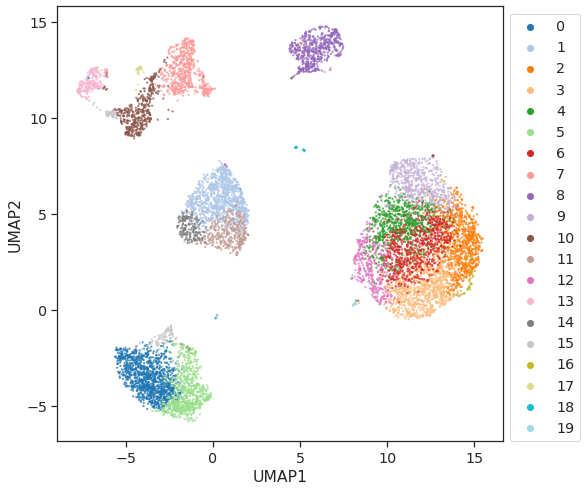

In [87]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### SPADE

In [91]:
clustering.global_clustering(method="spade", clustering_params=dict(sample_size=1000, min_k=5, max_k=10))

  0%|          | 0/6 [00:00<?, ?it/s]

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

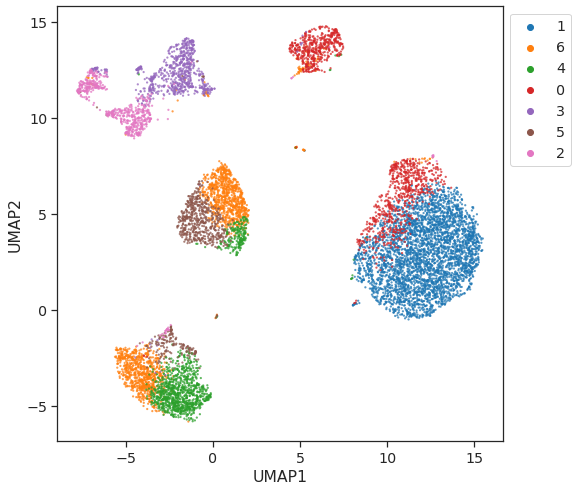

In [92]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### PARC

In [94]:
clustering.global_clustering(method="parc", clustering_params=dict(smallest_population=100, max_cluster_size=0.5))

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

Palette requires more than 20 unique colours, be careful interpreting results!
/home/ross/.cache/pypoetry/virtualenvs/cytocluster-9ecCQAJO-py3.8/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

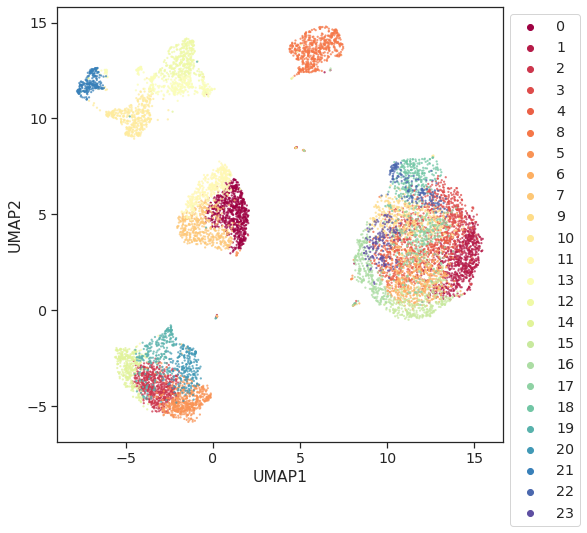

In [95]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### Using a Scikit-Learn like clustering algorithm

In [109]:
from sklearn.cluster import DBSCAN
clustering.global_clustering(method=DBSCAN(eps=0.5, min_samples=10), overwrite_features=["UMAP1", "UMAP2"])

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

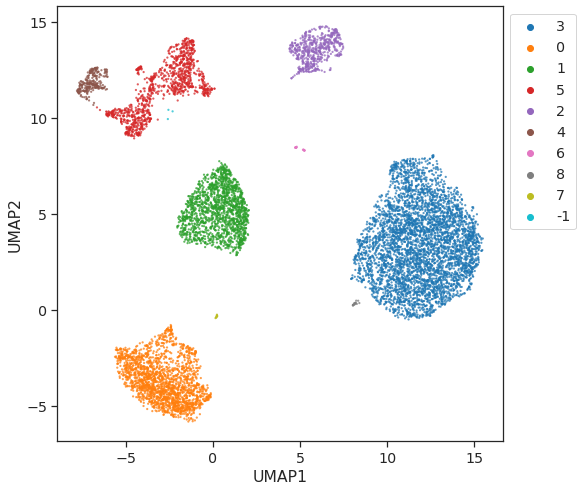

In [110]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))